# physic corpus feature extraction through tfidf
>Source
    https://www.kaggle.com/mrtroll/transfer-learning-on-stack-exchange-tags/physic-corpus-feature-extraction-through-tfidf-v1
    
Download nltk:
- wordnet
- averaged_perceptron_tagger
- punkt
- stopwords

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from subprocess import check_output
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [3]:
physic = pd.read_csv("../../input/test.csv")

In [4]:
physic.head(5)

,id,title,content
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...


In [5]:
punctuations = string.punctuation

def data_clean(data):
    print('Cleaning data')
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    data = data.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    data = data.apply(lambda i: ''.join(i.strip(punctuations))  )
    #print('tokenize')
    data = data.apply(lambda x: word_tokenize(x))

    #Select only the nouns
    is_noun = lambda pos: pos[:2] == 'NN' 
    for i in range(len(data)):
        data[i] = [word for (word, pos) in nltk.pos_tag(data[i]) if is_noun(pos)]
    
    #print('Lemmatizing')
    wordnet_lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [wordnet_lemmatizer.lemmatize(i) for i in x])
    data = data.apply(lambda x: [i for i in x if len(i)>2])
    return(data)

In [ ]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [6]:
def get_frequency(title):
    
    frequency = []
    inverse_frequency = {}
    for i in range(len(title)):
        word_count = {}

        for word in title[i]:
            if word in word_count:    
                word_count[word] = word_count[word] + 1
            else:
                word_count[word] = 1
                
        for word in word_count:
            if word in inverse_frequency:
                inverse_frequency[word] = inverse_frequency[word] + 1
            else:
                inverse_frequency[word] = 1            
        frequency.append(word_count)
        
    return (frequency, inverse_frequency)

In [16]:
title = data_clean(physic.title)

Cleaning data


In [17]:
frequency, inverse_frequency = get_frequency(title)

In [18]:
import operator
frequency_words = {}
for document in frequency:
    for word in document:
        if word in frequency_words:
            frequency_words[word] = frequency_words[word] + document[word]
        else:
            frequency_words[word] = document[word]            
frequency_words = sorted(frequency_words.values())

In [19]:
print('number of words:',len(frequency_words))

number of words: 14306


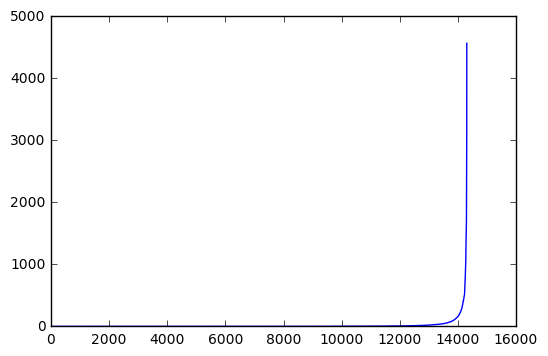

In [20]:
plt.plot(frequency_words)
plt.show()

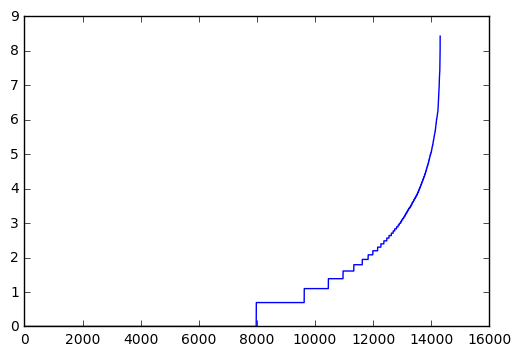

In [21]:
plt.plot(np.log(frequency_words))
plt.show()

In [22]:
tfidf = frequency

In [23]:
tfidf_distribution = []
for document in tfidf:
    if document == {}:
        continue
    max_frequency = sorted(document.items(), key=operator.itemgetter(1), reverse=True)[0][1]
    for word in document:
        document[word] = document[word]/(max_frequency + 0.0)*np.log(len(tfidf)/(inverse_frequency[word]+0.))
        tfidf_distribution.append(document[word])
    

In [24]:
index = 1

In [25]:
sorted(tfidf[index].items(), key=operator.itemgetter(1), reverse=True)

[('explanation', 5.4584997575763294),
 ('string', 5.2709388460963753),
 ('theory', 3.7091753309824185)]

In [26]:
print(physic.title[index])
print(physic.content[index])

What is your simplest explanation of the string theory?
<p>How would you explain string theory to non physicists such as myself? I'm specially interested on how plausible is it and what is needed to successfully prove it?</p>



In [27]:
tfidf_distribution = sorted(tfidf_distribution)
print(len(tfidf_distribution))

252458


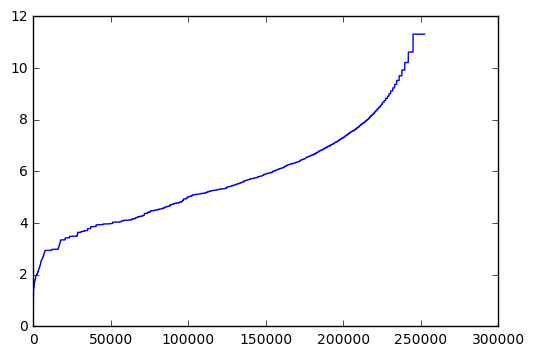

In [28]:
plt.plot(tfidf_distribution)
plt.show()

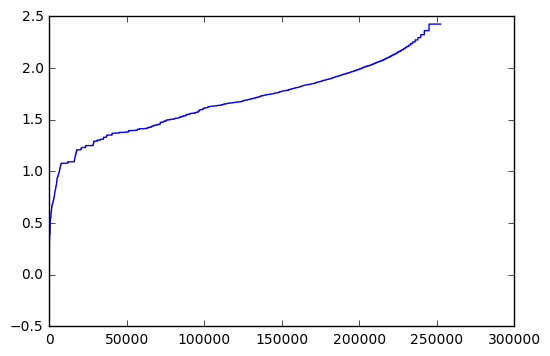

In [29]:
plt.plot(np.log(tfidf_distribution))
plt.show()

In [30]:
top = 8
output = []
for i in range(0,len(physic)):
    prediction = sorted(tfidf[i], key=tfidf[i].get, reverse=True)[0:top]
    output.append([physic.id[i], ' '.join(prediction)])

In [31]:
pd.DataFrame(data=output,columns = ['id','tags']).to_csv('Submission.csv', index=False)       